In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
import gc

from tqdm import tqdm
from IPython.display import clear_output

import os, sys
sys.path.append("..")

from src.tools import read_image_folder, ewma
from src import distributions
from src.autoencoders import CelebaAutoencoder
from src.autoencoders import VGGPerceptualLoss

## Config

In [2]:
CELEBA_64x64_PATH = '../data/img_align_celeba_64x64'
TRANSFORM = lambda x: 2 * x - 1
INV_TRANSFORM = lambda x: (x+1) / 2
GPU_DEVICE = 2
PERCEPTUAL = False
BATCH_SIZE = 128

In [3]:
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

## Data Loading

../src/distributions.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=self.dtype, requires_grad=False


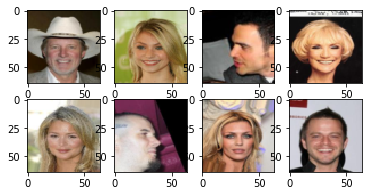

Batch stats:
Mix: 0.0, Max: 1.0, Mean: 0.4881156384944916, Std: 0.2835359275341034


In [4]:
images = read_image_folder(CELEBA_64x64_PATH, n_jobs=40)

dataset_uint8 = np.array([
    np.array(im, dtype=np.uint16) for im in images
]).astype(np.uint8).transpose(0, 3, 1 ,2)

del(images)
gc.collect()

Y_sampler = distributions.TensorDatasetSampler(
    dataset_uint8,
    transform=lambda x: TRANSFORM(x / 255.),
    storage='cpu',
    storage_dtype=torch.uint8,
    device='cuda',
    dtype=torch.float32,
    requires_grad=False
)

Y = INV_TRANSFORM(Y_sampler.sample(8).permute(0,2,3,1).cpu().detach().numpy())
fig, axes = plt.subplots(2, 4, figsize=(6, 3))
for i in range(8):
    axes.flatten()[i].imshow(Y[i])
plt.show()

print('Batch stats:')
print(f'Mix: {Y.min()}, Max: {Y.max()}, Mean: {Y.mean()}, Std: {Y.std()}')

del dataset_uint8
del Y, fig, axes
gc.collect()
torch.cuda.empty_cache()

## AutoEncoder

In [5]:
ae = CelebaAutoencoder(init_num_filters=128, embedding_dim=128, inter_fc_dim=512)
ae.cuda()
ae.train(True)
print(np.sum([np.prod(list(p.shape)) for p in ae.parameters()]), 'params in AutoEncoder')

55859584 params in AutoEncoder


In [ ]:
ae_opt = torch.optim.Adam(ae.parameters(), lr=1e-4, weight_decay=1e-15)

loss = np.inf
loss_history = []
noise_std = 0.025

In [ ]:
if PERCEPTUAL:
    PerceptualMSELoss = VGGPerceptualLoss().cuda()
    torch.cuda.empty_cache()

Epoch 0, iter 0 finished
10.708650065417721


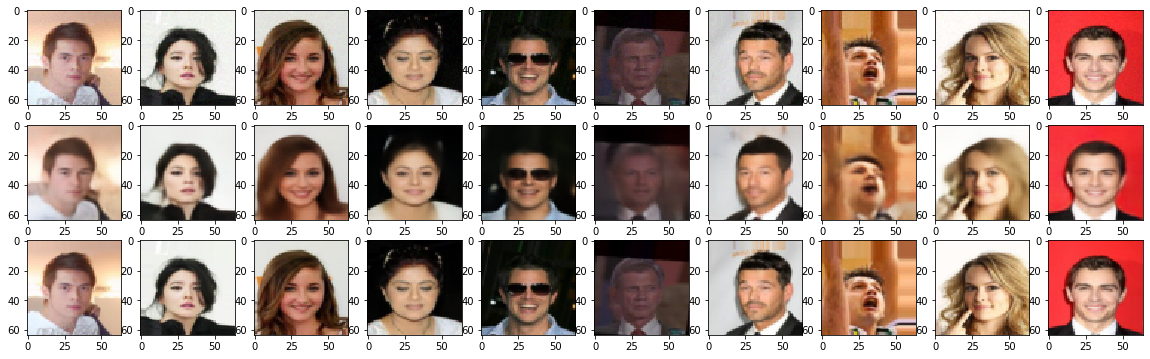

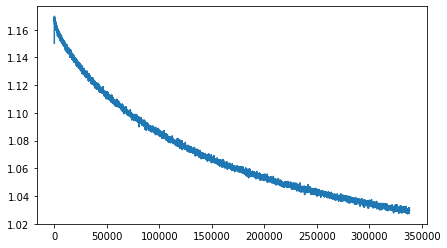

In [19]:
for approx_epoch in range(1000):
    for it in range(200000 // BATCH_SIZE):
        Y = Y_sampler.sample(BATCH_SIZE)
        Y_noised = (Y+ torch.randn_like(Y) * noise_std).detach()
        Y_recon = ae(Y_noised)[0]
        loss = 100 * F.l1_loss(Y_recon, Y) + 300 * F.mse_loss(Y_recon, Y)
        if PERCEPTUAL:
            loss += 6 * PerceptualMSELoss(Y_recon, Y)
        loss.backward()
        loss_history.append(loss)

        ae_opt.step()
        ae_opt.zero_grad()

        if it % 500 == 0:
            clear_output(wait=True)
            print(f"Epoch {approx_epoch}, iter {it} finished")
            print(ewma(loss_history)[-1])
            
            Y = INV_TRANSFORM(Y[:20]).permute(0,2,3,1).cpu().detach().numpy().clip(0,1)
            Y_recon = INV_TRANSFORM(Y_recon[:20]).permute(0,2,3,1).cpu().detach().numpy().clip(0,1)
            Y_noised = INV_TRANSFORM(Y_noised[:20]).permute(0,2,3,1).cpu().detach().numpy().clip(0,1)

            fig, axes = plt.subplots(3, 10, figsize=(20, 6))
            for i in range(10):
                axes[0, i].imshow(Y_noised[i])
                axes[1, i].imshow(Y_recon[i])
                axes[2, i].imshow(Y[i])

            plt.show()
            plt.close(fig)
            
            fig, ax = plt.subplots(1, 1, figsize=(7, 4))
            ax.plot(np.log10(ewma(loss_history)))

            plt.show()
            plt.close(fig)

In [17]:
if PERCEPTUAL:
    torch.save(ae.state_dict(), '../models/ae_celeba_vgg.tsd')
else:
    torch.save(ae.state_dict(), '../models/ae_celeba_mse.tsd')